# Overview

This exercise demonstrates how TEMPO data can be used to track and assess ozone precursors and ozone formation potential, in support of assessing ozone exceedances.

**Notebook Author / Affiliation**

* Author: Carl Malings / NASA ARSET
* This notebook is based on examples from the [ASDC Data and User Services Github](https://github.com/nasa/ASDC_Data_and_User_Services).

## Package Installation and Setup

*Instructions*

* Run the cell below to install the non-standard packages required for this exercise.

*NOTE: This also includes the pyrisg package, in addition to those used in previous exercises*

In [ ]:
!pip install --quiet harmony-py cartopy pyrsig

*Instructions*

* Run the code cell below to import the required packages.

In [45]:
# Downloading TEMPO data
import datetime as dt
import getpass
import os
from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

# Opening TEMPO data files
import xarray as xr

# Creating graphics
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray.plot.utils import label_from_attrs

# Downloading AirNow data
import pyrsig

# Working with data tables
import numpy as np
import pandas as pd

# Download TEMPO NO2 and HCHO Data

The first part of this exercise will be to download the TEMPO NO2 and HCHO data for the region and time period of interest.

*Instructions*

* Run the cell below and enter your Earthdata credentials to prepare for data downloading

In [46]:
username = input("Username:")

harmony_client = Client(env=Environment.PROD, auth=(username, getpass.getpass()))

Username:carl_malings
··········


## Get TEMPO Level-3 NO2 Data

The below code is copied from previous examples of downloading TEMPO data. You will use it to download TEMPO Level-3 NO2 data for a region and time period of inerest.

**Region of Interest**: Colorado Front Range (latitude 38 to 41, longitude -106 to -103)

**Time of Interest**: July 27 to 30, 2024

*Instructions*

* Modify the code in the next cells to download the TEMPO Level-3 NO2 data product for the region and time period of interest.

* Run the cells in sequence to download the desired TEMPO data.

<details>

*Hint*: You will need to modify the `RoI`, `Collection id`, `start` and `stop` times.

*Hint*: Use [Earthdata Search](https://search.earthdata.nasa.gov/search) to get the Collection id.

</details>

*Build the request*

In [47]:
# This list will save the bounding box limits for later use:
RoI = [-106, 38, -103, 41]

# Structure the request:
request_no2 = Request(
    collection=Collection(id='C2930763263-LARC_CLOUD'),
    temporal={
        'start': dt.datetime(2024, 7, 27),
        'stop': dt.datetime(2024, 7, 30)
    },
    spatial=BBox(RoI[0], RoI[1], RoI[2], RoI[3]),
)

# Check the request is valid:
request_no2.is_valid()

True

*Submit and monitor the request*

In [48]:
job_id_no2 = harmony_client.submit(request_no2)
print(f"jobID = {job_id_no2}")

harmony_client.wait_for_processing(job_id_no2, show_progress=True)

jobID = 0bc08097-67bc-4140-a32c-28bddefaee85


 [ Processing: 100% ] |###################################################| [|]


*Download the results*

In [49]:
download_dir = os.path.expanduser("~/tempo_data_ozone_precursor_exercise")
os.makedirs(download_dir, exist_ok=True)

results_no2 = harmony_client.download_all(job_id_no2, directory=download_dir)
all_results_stored_no2 = [f.result() for f in results_no2]

print(f"Number of files: {len(all_results_stored_no2)}")

/root/tempo_data_ozone_precursor_exercise/105977290_TEMPO_NO2_L3_V03_20240727T001142Z_S017_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977291_TEMPO_NO2_L3_V03_20240727T005147Z_S018_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977289_TEMPO_NO2_L3_V03_20240726T233137Z_S016_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977292_TEMPO_NO2_L3_V03_20240727T103122Z_S001_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977293_TEMPO_NO2_L3_V03_20240727T111127Z_S002_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977294_TEMPO_NO2_L3_V03_20240727T115132Z_S003_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977295_TEMPO_NO2_L3_V03_20240727T123137Z_S004_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977303_TEMPO_NO2_L3_V03_20240727T215147Z_S013_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977299_TEMPO_NO2_L3_V03_20240727T175147Z_S009_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977296_TEM

*Open the files and combine into a single Dataset*

In [50]:
# Create empty lists for the TEMPO NO2 and QC data:
data_list_no2 = []
data_list_qc = []
# Loop through the result files:
for result_file in sorted(all_results_stored_no2):
    # For each file, add the NO2 or QC data from that file to the appropriate list:
    data_list_no2 += [xr.open_datatree(result_file)['product/vertical_column_troposphere']]
    data_list_qc += [xr.open_datatree(result_file)['product/main_data_quality_flag']]

# Concatenate each list into a Dataset along the time dimenion:
tempo_data_no2_raw = xr.concat(data_list_no2,dim='time')
tempo_data_qc = xr.concat(data_list_qc,dim='time')

# Merge both Datasets together:
tempo_data_no2 = xr.merge([tempo_data_no2_raw,tempo_data_qc])

# Examine the result:
tempo_data_no2

<xarray.Dataset> Size: 14MB
Dimensions:                      (longitude: 150, latitude: 150, time: 53)
Coordinates:
  * longitude                    (longitude) float32 600B -106.0 ... -103.0
  * latitude                     (latitude) float32 600B 38.01 38.03 ... 40.99
  * time                         (time) datetime64[ns] 424B 2024-07-26T23:31:...
Data variables:
    vertical_column_troposphere  (time, latitude, longitude) float64 10MB 6.3...
    main_data_quality_flag       (time, latitude, longitude) float32 5MB 0.0 ...
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

*Apply quality control*

<details>

For this exercise, we will accept Suspect data, to examine what effect this will have on our analysis.

*Hint:* TEMPO quality flags are:

* `0` = Normal quality (use for analysis)

* `1` = Suspect quality (use with caution)

* `2` = Bad quality (exclude from analysis)

</details>

In [51]:
tempo_data_no2 = tempo_data_no2.where(tempo_data_no2['main_data_quality_flag'] <= 1).squeeze()

## Get TEMPO Level-3 HCHO Data

The below code is copied from previous examples of downloading TEMPO data. You will use it to download TEMPO Level-3 HCHO data for a region and time period of inerest.

**Region of Interest**: Colorado Front Range (latitude 38 to 41, longitude -106 to -103)

**Time of Interest**: July 27 to 30, 2024

*Instructions*

* Modify the code in the next cells to download the TEMPO Level-3 HCHO data product for the region and time period of interest.

* Run the cells in sequence to download the desired TEMPO data.

<details>

*Hint*: You will need to modify the `RoI`, `Collection id`, `start` and `stop` times.

*Hint*: Use [Earthdata Search](https://search.earthdata.nasa.gov/search) to get the Collection id.

</details>

*Build the request*

In [52]:
# Structure the request:
request_hcho = Request(
    collection=Collection(id='C2930761273-LARC_CLOUD'),
    temporal={
        'start': dt.datetime(2024, 7, 27),
        'stop': dt.datetime(2024, 7, 30)
    },
    spatial=BBox(RoI[0], RoI[1], RoI[2], RoI[3]),
)

# Check the request is valid:
request_hcho.is_valid()

True

*Submit and monitor the request*

In [53]:
job_id_hcho = harmony_client.submit(request_hcho)
print(f"jobID = {job_id_hcho}")

harmony_client.wait_for_processing(job_id_hcho, show_progress=True)

 [ Processing:   0% ] |                                                   | [/]

jobID = 7c0a7682-2f0b-47dd-9b74-e5d4c03ded0c


 [ Processing: 100% ] |###################################################| [|]


*Download the results*

In [62]:
results_hcho = harmony_client.download_all(job_id_hcho, directory=download_dir)
all_results_stored_hcho = [f.result() for f in results_hcho]

print(f"Number of files: {len(all_results_stored_hcho)}")

/root/tempo_data_ozone_precursor_exercise/105977365_TEMPO_HCHO_L3_V03_20240727T103122Z_S001_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977366_TEMPO_HCHO_L3_V03_20240727T111127Z_S002_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977369_TEMPO_HCHO_L3_V03_20240727T131142Z_S005_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977368_TEMPO_HCHO_L3_V03_20240727T123137Z_S004_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977363_TEMPO_HCHO_L3_V03_20240727T001142Z_S017_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977364_TEMPO_HCHO_L3_V03_20240727T005147Z_S018_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977367_TEMPO_HCHO_L3_V03_20240727T115132Z_S003_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977362_TEMPO_HCHO_L3_V03_20240726T233137Z_S016_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/105977374_TEMPO_HCHO_L3_V03_20240727T195147Z_S011_subsetted.nc4
/root/tempo_data_ozone_precursor_exercise/1059

*Open the files and combine into a single Dataset*

<details>

* In addition to the HCHO and QC variables, we are also extracting the effective cloud fraction from this dataset, for later use to analyse the impact of cloud fraction on the results.

</details>

In [63]:
# Create empty lists for the TEMPO HCHO and QC data:
data_list_hcho = []
data_list_qc = []
data_list_cloudfraction = []
# Loop through the result files:
for result_file in sorted(all_results_stored_hcho):
    # For each file, add the HCHO or QC data from that file to the appropriate list:
    data_list_hcho += [xr.open_datatree(result_file)['product/vertical_column']]
    data_list_qc += [xr.open_datatree(result_file)['product/main_data_quality_flag']]
    data_list_cloudfraction += [xr.open_datatree(result_file)['support_data/eff_cloud_fraction']]

# Concatenate each list into a Dataset along the time dimenion:
tempo_data_hcho_raw = xr.concat(data_list_hcho,dim='time')
tempo_data_qc = xr.concat(data_list_qc,dim='time')
tempo_data_cloudfraction = xr.concat(data_list_cloudfraction,dim='time')

# Merge both Datasets together:
tempo_data_hcho = xr.merge([tempo_data_hcho_raw,tempo_data_qc,tempo_data_cloudfraction])

# Examine the result:
tempo_data_hcho

<xarray.Dataset> Size: 19MB
Dimensions:                 (longitude: 150, latitude: 150, time: 53)
Coordinates:
  * longitude               (longitude) float32 600B -106.0 -106.0 ... -103.0
  * latitude                (latitude) float32 600B 38.01 38.03 ... 40.97 40.99
  * time                    (time) datetime64[ns] 424B 2024-07-26T23:31:55.14...
Data variables:
    vertical_column         (time, latitude, longitude) float64 10MB 4.788e+1...
    main_data_quality_flag  (time, latitude, longitude) float32 5MB 0.0 ... 0.0
    eff_cloud_fraction      (time, latitude, longitude) float32 5MB 0.9461 .....
Attributes:
    long_name:  formaldehyde vertical column
    comment:    formaldehyde vertical column determined from fitted slant col...
    units:      molecules/cm^2

*Apply quality control*

<details>

For this exercise, we will accept Suspect data, to examine what effect this will have on our analysis.

*Hint:* TEMPO quality flags are:

* `0` = Normal quality (use for analysis)

* `1` = Suspect quality (use with caution)

* `2` = Bad quality (exclude from analysis)

</details>

In [64]:
tempo_data_hcho = tempo_data_hcho.where(tempo_data_hcho['main_data_quality_flag'] <= 1).squeeze()

## Combine into a single TEMPO Dataset

To facilitate analysis, it will help if all the data are in one dataset. However, the `main_data_quality_flag` is present in both datasets, which will cause an issue if they are combined.

*Instructions*

* First, write code to give the variables in each dataset new, unique names.

* Second, merge the datasets together into one.

<details>

*Hint*: To rename variables in a dataset, use the following code example:

```
dataset = dataset.rename({'old_name':'new_name'})
```

*Hint*: To merge datasets together, use the following code example:

```
merged_dataset = xr.merge([dataset_1,dataset_2])
```


</details>

In [65]:
# Rename the variables in each dataset:
tempo_data_no2 = tempo_data_no2.rename({'vertical_column_troposphere':'no2_vertical_column_troposphere',
                                        'main_data_quality_flag':'no2_qc_flag'
                                        })
tempo_data_hcho = tempo_data_hcho.rename({'vertical_column':'hcho_vertical_column',
                                          'main_data_quality_flag':'hcho_qc_flag'})

# Merge the datasets together:
tempo_data = xr.merge([tempo_data_no2,tempo_data_hcho])

# Examine the results:
tempo_data

<xarray.Dataset> Size: 33MB
Dimensions:                          (time: 53, latitude: 150, longitude: 150)
Coordinates:
  * longitude                        (longitude) float32 600B -106.0 ... -103.0
  * latitude                         (latitude) float32 600B 38.01 ... 40.99
  * time                             (time) datetime64[ns] 424B 2024-07-26T23...
Data variables:
    no2_vertical_column_troposphere  (time, latitude, longitude) float64 10MB ...
    no2_qc_flag                      (time, latitude, longitude) float32 5MB ...
    hcho_vertical_column             (time, latitude, longitude) float64 10MB ...
    hcho_qc_flag                     (time, latitude, longitude) float32 5MB ...
    eff_cloud_fraction               (time, latitude, longitude) float32 5MB ...
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

# Analyse the Formaldehyde-to-NO2 Ratios

The second part of this exercise will be to assess the Formaldehyde-to-NO2 ratios from TEMPO data for the region and time period of interest.

## Calculate the Formaldehyde-to-NO2 ratio

*Instructions*

* Write code to compute the Formaldehyde-to-NO2 Ratio from the TEMPO data

<details>

*Hint*: You can divide variables in a dataset to create a new varaible with the following code example:

```
dataset['a_divided_by_b'] = dataset['a']/dataset['b']
```

</details>

In [66]:
# Calculate the ratio:
tempo_data['fnr'] = tempo_data['hcho_vertical_column']/tempo_data['no2_vertical_column_troposphere']

# Examine the result:
tempo_data['fnr']

<xarray.DataArray 'fnr' (time: 53, latitude: 150, longitude: 150)> Size: 10MB
array([[[ 7.50665658e+01,  2.61372374e+02,  2.38404389e+02, ...,
          1.15232624e+01,  1.18958830e+01,  1.28896426e+01],
        [ 3.58371819e+01,  3.54300587e+01,  3.44182964e+01, ...,
          2.89007601e+01,  2.58112909e+01,  2.47878982e+01],
        [ 2.47253475e+01,  2.42113139e+01,  1.74075565e+01, ...,
          3.84401820e+00,  6.20790409e+00,  7.99571230e+00],
        ...,
        [ 3.49282134e+00,  7.62484110e+00,  9.63755102e+00, ...,
         -3.99432021e+00,  1.10819874e+01,  1.23597016e+01],
        [ 1.08620310e+00,  8.01467396e+00,  7.93638947e+00, ...,
         -4.90062631e+00, -9.27582290e+01, -9.73293962e+01],
        [-1.97167478e+01,  1.69900804e+01,  2.75807544e+01, ...,
          1.84834705e+03, -9.74233220e+01, -8.73999831e+01]],

       [[ 1.67726647e+01,  1.63000311e+01,  1.59589689e+01, ...,
          1.06881815e+01,  9.14157057e+00,  6.15056977e+00],
        [ 1.04112138e+01,  1.04873772e+01,  1.10517732e+01, ...,
          1.37703002e+01,  1.11043372e+01,  3.28444158e+00],
        [ 1.23897717e+01,  1.24960947e+01,  1.06056196e+01, ...,
          3.18318830e+00,  2.52282855e+00,  1.66591263e+00],
...
        [ 1.09891480e+01, -9.46670978e+00, -1.21004780e+01, ...,
          4.23664697e+00,  9.94115610e+00,  1.07474809e+01],
        [ 6.07678157e+00, -2.40891037e+00, -1.84097955e+00, ...,
          2.48832965e+00,  5.53261698e+00,  5.40660486e+00],
        [ 2.95319793e+02, -3.64970983e+00, -3.43045276e+00, ...,
          4.68229082e+00,  3.08200980e+00,  3.09948856e+00]],

       [[ 2.35465091e+01,  2.53362986e+01,  5.69992280e+00, ...,
          5.54114852e+00, -2.66152863e+01, -4.87514363e+01],
        [ 1.90205554e+01,  1.72858879e+01,  2.97143891e+00, ...,
         -6.04495790e+00,  4.29983825e-01,  3.32860944e-01],
        [ 3.90411248e+00,  3.65838994e+00, -1.32205816e-02, ...,
          3.05346474e+01,  3.18059825e+00,  3.47064570e+00],
        ...,
        [ 1.47338347e+01,  1.71072342e+01,  1.67915390e+01, ...,
          4.67648809e+00,  5.05623714e+00,  5.12476317e+00],
        [ 2.68644665e+00,  1.92040935e+00,  1.39430210e+00, ...,
          7.20668523e+00,  7.34320941e+00,  7.31263421e+00],
        [-9.56350523e+00, -6.96918715e+00, -2.05566540e+01, ...,
          5.14331938e+00,  5.00731495e+00,  4.54977971e+00]]])
Coordinates:
  * longitude  (longitude) float32 600B -106.0 -106.0 -105.9 ... -103.0 -103.0
  * latitude   (latitude) float32 600B 38.01 38.03 38.05 ... 40.95 40.97 40.99
  * time       (time) datetime64[ns] 424B 2024-07-26T23:31:55.148317952 ... 2...

## Plot Maps of Formaldehyde-to-NO2 Ratios

The code below is taken from earlier plotting examples, with slight modifications.

*Instructions*

* Examine the code example below and determine where it is trying to get the Formaldehyde-to-NO2 ratio from.

* Replace this with the appropriate dataset variable from your code.

* Run the cell and check the output.

* Try picking different timestamps to plot and examining the output.

<details>

*Hint*: The code example assumes that `tempo_data['fnr']` is the source of the Formaldehyde-to-NO2 ratio.

*Hint*: There is a set of code at the bottom you can try to uncomment and modify to plot all timestamps in a loop.

</details>


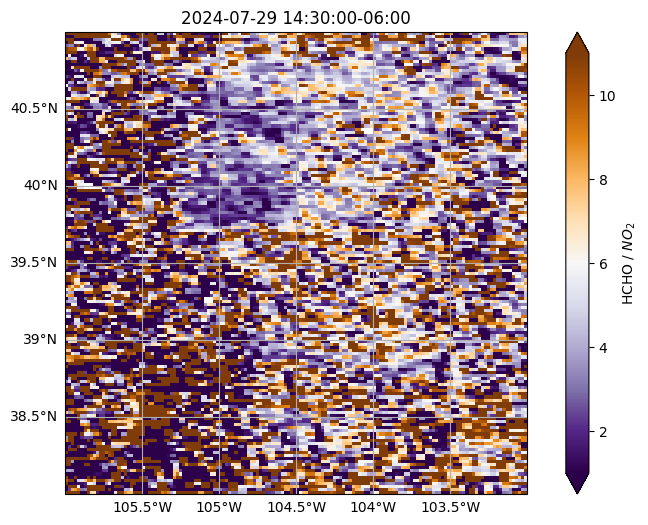

In [123]:
data_proj = ccrs.PlateCarree()

def make_nice_map(axis):
    axis.add_feature(cfeature.STATES.with_scale('50m'), edgecolor="black", linewidth=0.5)
    axis.coastlines(resolution="50m", color="black", linewidth=1.0)

    axis.set_extent([RoI[0], RoI[2], RoI[1], RoI[3]], crs=data_proj)
    grid = axis.gridlines(draw_labels=["left", "bottom"], dms=True)
    grid.xformatter = LONGITUDE_FORMATTER
    grid.yformatter = LATITUDE_FORMATTER

# Choose a timestamp to plot:
timestamp_local = pd.Timestamp('2024-07-29 14:30:00',tz='America/Denver')

# Convert the timestamp from local time to UTC
timestamp_utc = timestamp_local.tz_convert(tz='UTC').to_datetime64()

# Select the Formaldehyde-to-NO2 ratio data to plot
data_to_plot = tempo_data['fnr'].sel(time=timestamp_utc,method='nearest')

# Plot the data on a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})

make_nice_map(ax)

data_to_plot.plot(
    ax=ax, # axis to add plot to
    cmap=plt.get_cmap('PuOr_r'), # color scale
    vmin=1, # minimum value
    vmax=11, # maximum value
    cbar_kwargs={'label':'HCHO / $NO_2$'} # set colorbar label
)

ax.set_title(timestamp_local)

plt.show()

# Uncomment the code below to plot all timestamps:
#fig, axs = plt.subplots(
#    nrows=len(tempo_data.time.values),
#    sharex=True,
#    figsize=(5, 50),
#    gridspec_kw=dict(hspace=0.5),
#    subplot_kw={"projection": data_proj},
#)

#for i,timestamp in enumerate(tempo_data.time.values):
#    Var = tempo_data.sel(time=timestamp)['fnr']
#    make_nice_map(axs[i])
#    Var.plot(ax=axs[i],cmap=plt.get_cmap('PuOr'),vmin=1,vmax=11,cbar_kwargs={'label':'HCHO / $NO_2$'})
#    axs[i].set_title(pd.Timestamp(timestamp,tz='UTC').tz_convert(tz=''America/Denver'').to_datetime64(), fontsize=8)

#plt.show()

## Plot Long-term Average Maps of Formaldehyde-to-NO2 Ratios

In most of these plots, there is a lot of noise to the data, making it hard to draw conclusions. By averaging over time, we can get a more stable result. By providing multiple observations per day, TEMPO allows for more robust averages in shorter periods of time.

This code is similar to the above, except instead of plotting a single timestamp, it plots an average for a pariod of time. To make a more robust average, instead of plotting the average of ratios, we will first take the average of the HCHO and NO2, and then plot the ratio.

*Instructions*

* In the code template below, write code which will select a subset of the data between `timestamp_utc_start` and `timestamp_utc_stop`, take the average of that data over time, and compute a Formaledhyde-to-NO2 ratio for that average.

* Run the cell and check the output.

* Try picking different starting and stopping timestamps to plot and examining the output.

<details>

*Hint*: The following code example shows how to select a subset of data by selecting between a `start_time` and `stop_time`:

```
data_subset_by_time = data.sel(time=slice(start_time,stop_time))
```

*Hint*: The following code example shows how to average a dataset in the dimension `'time'`:

```
data_average_by_time = data.mean('time')
```

</details>


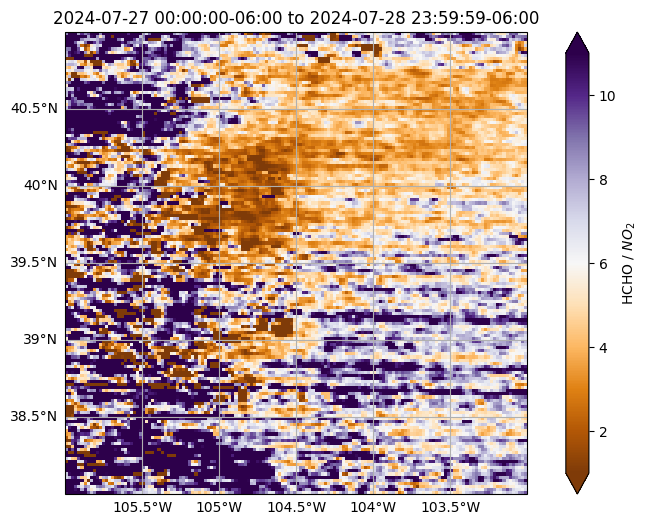

In [122]:
# Choose timestamp to start and stop the averaging:
timestamp_local_start = pd.Timestamp('2024-07-27 00:00:00',tz='America/Denver')
timestamp_local_stop = pd.Timestamp('2024-07-28 23:59:59',tz='America/Denver')

# Convert the timestamps from local time to UTC:
timestamp_utc_start = timestamp_local_start.tz_convert(tz='UTC')
timestamp_utc_stop = timestamp_local_stop.tz_convert(tz='UTC')

# Subset the TEMPO data for the selected time:
data_subset = tempo_data.sel(time=slice(timestamp_utc_start.to_datetime64(),timestamp_utc_stop.to_datetime64()))

# Compute the ratio to plot:
average_ratio_to_plot = data_subset['hcho_vertical_column'].mean('time')/data_subset['no2_vertical_column_troposphere'].mean('time')

# Plot the data on a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})

make_nice_map(ax)

average_ratio_to_plot.plot(
    ax=ax, # axis to add plot to
    cmap=plt.get_cmap('PuOr'), # color scale
    vmin=1, # minimum value
    vmax=11, # maximum value
    cbar_kwargs={'label':'HCHO / $NO_2$'} # set colorbar label
)

ax.set_title(f'{timestamp_local_start} to {timestamp_local_stop}')

plt.show()

## Screen Data by Cloud Fraction

There is still noise in the above plots. One way to reduce this noise might be to screen for only pixels with low cloud cover.

*Instructions*

* Duplicate your code for computing the Formaledhyde-to-NO2 ratio for a time period average from the previous cell.

* Add an additional step which screens the data for a maximum effective cloud fraction. To start, try screening for data where the effective cloud fraction is below 0.25.

* Run the cell and check the output.

* Try picking different effective cloud fraction screens and examine the output.

<details>

*Hint*: The following code example shows how to screen a dataset with a conditional statement:

```
screened_data = data.where(condition).squeeze()
```

*Hint*: See the code above for screening data according the the quality flags for more examples.

</details>


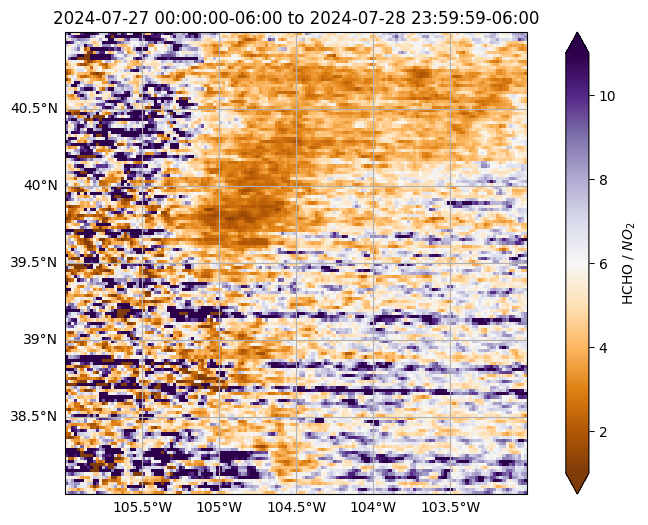

In [120]:
# Choose timestamp to start and stop the averaging:
timestamp_local_start = pd.Timestamp('2024-07-27 00:00:00',tz='America/Denver')
timestamp_local_stop = pd.Timestamp('2024-07-28 23:59:59',tz='America/Denver')

# Convert the timestamps from local time to UTC:
timestamp_utc_start = timestamp_local_start.tz_convert(tz='UTC')
timestamp_utc_stop = timestamp_local_stop.tz_convert(tz='UTC')

# Subset the TEMPO data for the selected time:
data_subset = tempo_data.sel(time=slice(timestamp_utc_start.to_datetime64(),timestamp_utc_stop.to_datetime64()))

# Screen the TEMPO data subset by effective cloud fraction:
data_subset = data_subset.where(data_subset['eff_cloud_fraction'] < 0.25).squeeze()

# Compute the ratio to plot:
average_ratio_to_plot = data_subset['hcho_vertical_column'].mean('time')/data_subset['no2_vertical_column_troposphere'].mean('time')

# Plot the data on a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})

make_nice_map(ax)

average_ratio_to_plot.plot(
    ax=ax, # axis to add plot to
    cmap=plt.get_cmap('PuOr'), # color scale
    vmin=1, # minimum value
    vmax=11, # maximum value
    cbar_kwargs={'label':'HCHO / $NO_2$'} # set colorbar label
)

ax.set_title(f'{timestamp_local_start} to {timestamp_local_stop}')

plt.show()

# Bonus: Compare with AirNow Ozone Monitor Data

We can add the surface Ozone monitor data into our plots for additional context.

## Use pyrsig to download AirNow ozone

We will use the [pyrsig package](https://barronh.github.io/pyrsig/) to easily bring the AirNow ozone data into python. Below is a template for how a query is structured and submitted to pyrsig. The result will be a data table with the ozone data, timestamps, and station information.

*Instructions*

* Modify the template to have the approrpiate start end and dates.

* Modify the template to have the appropriate bounding box for the region of interest.

* Run the cell to examine the output table.

In [114]:
# Define the query for pyrisg:
api = pyrsig.RsigApi(bdate="2024-07-27", # start date of the query, in the format "YYYY-MM-DD"
                     edate="2024-07-30", # end date of the query, in the format "YYY-MM-DD"
                     bbox=(RoI[0],RoI[1],RoI[2],RoI[3]), # bounding box for the query, in the format (minimum_longitude,minimum_latitude,maximum_longitude,maximum_latitude)
                     workdir=download_dir, # temporary directory to store the downloaded data
                     gridfit=True) # data are not being re-aligned to a grid
airnowkey = "airnow.ozone" # this is the pyrsig code to specify ozone data from AirNow

# Execute the query to download the data:
airnow_data = api.to_dataframe(airnowkey, unit_keys=False, parse_dates=True)

# Examine the resulting table:
airnow_data

Using cached: /root/tempo_data_ozone_precursor_exercise/airnow.ozone_2024-07-27T000000Z_2024-07-30T000000Z.csv.gz


,Timestamp,LONGITUDE,LATITUDE,STATION,ozone,SITE_NAME,time
0,2024-07-27T00:00:00-0000,-104.94890,39.83920,7703,64.0,840080013001;44201,2024-07-27 00:00:00+00:00
1,2024-07-27T00:00:00-0000,-104.95720,39.56890,7705,49.0,840080050002;44201,2024-07-27 00:00:00+00:00
2,2024-07-27T00:00:00-0000,-104.56906,39.63854,7707,66.0,840080050006;44201,2024-07-27 00:00:00+00:00
3,2024-07-27T00:00:00-0000,-105.22023,40.07001,7713,60.0,840080130014;44201,2024-07-27 00:00:00+00:00
4,2024-07-27T00:00:00-0000,-104.98720,39.75110,7717,63.0,840080310002;44201,2024-07-27 00:00:00+00:00
...,...,...,...,...,...,...,...
1450,2024-07-30T00:00:00-0000,-104.94999,40.51508,7750,60.0,840080690016;44201,2024-07-30 00:00:00+00:00
1451,2024-07-30T00:00:00-0000,-105.07940,40.57640,7751,63.0,840080691004;44201,2024-07-30 00:00:00+00:00
1452,2024-07-30T00:00:00-0000,-104.72250,38.30333,7768,53.0,840081010016;44201,2024-07-30 00:00:00+00:00
1453,2024-07-30T00:00:00-0000,-104.73670,40.38610,7775,71.0,840081230009;44201,2024-07-30 00:00:00+00:00


## Map Comparison Plot

Finally, we will overlay ozone monitor averages onto an Formaldehyde-to-NO2 ratio map. The code example below should generate this plot, but again, it assumes the data are in specifically named datasets which might not exist in your run of the code.

*Instructions*

* Examine the code and see if you can understand what is happening in each part.

* Try to run the code below, troubleshooting any errors you encounter.

* Try changing the axis limits on the ozone plot colorbar.

<details>

*Hint*: If youn are getting errors, try copying subsets of the code into a new cell to run it incrementally, and see where the errors are coming from. Put the name of a variable in a cell by itself and run that cell to see what the variable looks like.

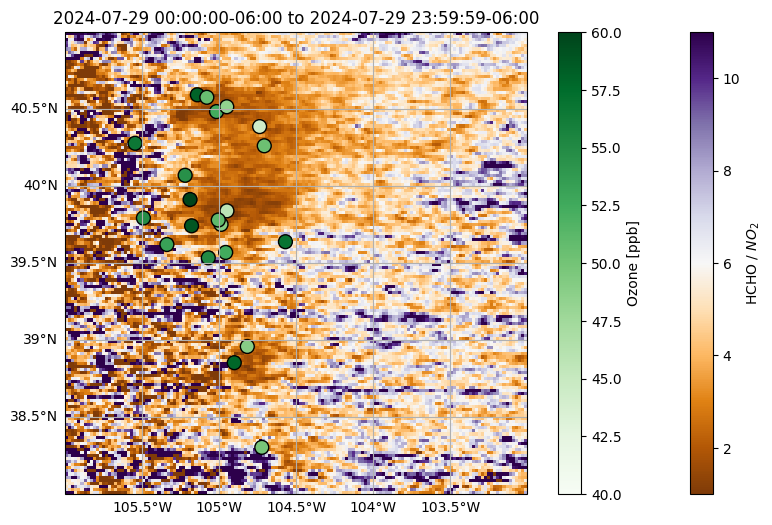

In [118]:
# Choose timestamp to start and stop the averaging:
timestamp_local_start = pd.Timestamp('2024-07-29 00:00:00',tz='America/Denver')
timestamp_local_stop = pd.Timestamp('2024-07-29 23:59:59',tz='America/Denver')

# Convert the timestamps from local time to UTC:
timestamp_utc_start = timestamp_local_start.tz_convert(tz='UTC')
timestamp_utc_stop = timestamp_local_stop.tz_convert(tz='UTC')

# Subset the TEMPO data for the selected time:
data_subset = tempo_data.sel(time=slice(timestamp_utc_start.to_datetime64(),timestamp_utc_stop.to_datetime64()))

# Screen the TEMPO data subset by effective cloud fraction:
data_subset = data_subset.where(data_subset['eff_cloud_fraction'] < 0.25).squeeze()

# Compute the ratio to plot:
average_ratio_to_plot = data_subset['hcho_vertical_column'].mean('time')/data_subset['no2_vertical_column_troposphere'].mean('time')

# Subset the AirNow ozone data to plot:
airnow_data_subset = airnow_data.where((airnow_data['time'] >= timestamp_utc_start) & (airnow_data['time'] < timestamp_utc_stop)).dropna(how='all')

# Compute the average:
average_ozone_to_plot = airnow_data_subset[['STATION','LATITUDE','LONGITUDE','ozone']].groupby('STATION').mean()

# Plot the data on a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})

make_nice_map(ax)

ratio_plot = average_ratio_to_plot.plot(
    ax=ax, # axis to add plot to
    cmap=plt.get_cmap('PuOr'), # color scale
    vmin=1, # minimum value
    vmax=11, # maximum value
    add_colorbar=False
)

colorbar_ratio = plt.colorbar(ratio_plot)
colorbar_ratio.set_label('HCHO / $NO_2$')

ozone_plot = ax.scatter(average_ozone_to_plot['LONGITUDE'],
                        average_ozone_to_plot['LATITUDE'],
                        s=100,
                        c=average_ozone_to_plot['ozone'],
                        cmap=plt.get_cmap('Greens'),
                        vmin=40,
                        vmax=60,
                        edgecolors='black')

colorbar_ozone = plt.colorbar(ozone_plot)
colorbar_ozone.set_label('Ozone [ppb]')

ax.set_title(f'{timestamp_local_start} to {timestamp_local_stop}')

plt.show()